<a href="https://colab.research.google.com/github/Jorbnc/MAIA-RL/blob/master/RL_proyecto_Primera_Entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

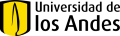

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***
# Proyecto de Aprendizaje por Refuerzo
### Primera Entrega

***
## Descripción del problema

Se debe crear un agente de Aprendizaje por Refuerzo (RL) que juegue una versión simplificada de Escaleras y Rodaderos (*Snakes & Ladders*) sobre un tablero fijo de **10 × 10** (**100** casillas).

El agente parte siempre de la casilla **1** y, en cada turno, solo puede avanzar o retroceder en la secuencia lineal de casillas.

Algunas casillas son inicios de escaleras o rodaderos; al pisarlas, el agente se transporta determinísticamente a su casilla final.

El reto del proyecto abarca definir formalmente el **MDP** (espacio de estados, acciones, función de transición y recompensas), escoger/implementar la estrategia de RL (por ejemplo *Q-learning*, *SARSA*, etc.), entrenar al agente y demostrar su desempeño en un vídeo y con la Q-tabla resultante.


> **Objetivo de Aprendizaje:**  
> Al finalizar el proyecto, nosotros los estudiantes debemos poder modelar un problema real como un Proceso de Decisión de Markov discreto e implementar un agente de Aprendizaje por Refuerzo capaz de aprender una política óptima mediante interacción directa con el ambiente, evaluando su rendimiento a partir de métricas objetivas (recompensa acumulada, episodios hasta solución) y justificando las decisiones de diseño (elección de algoritmo, parámetros, representación de estados y recompensas)

<div class="alert alert-block alert-info">
<bNotar:</b >

**Esta entrega parcial del proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 6 de mayo.**
</div24></span>

***
# 📑 Índice

| 🔹 | Sección        |
|----|----------------|
| 1️⃣ | **Importaciones** |
| 2️⃣ | **Tablero**       |
| 3️⃣ | **Agente**        |
| 4️⃣ | **Visualización** |
| 5️⃣ | **Simulación**    |
| 6️⃣ | **Main**          |
| 7️⃣ | **Referencias**   |

***
# Tareas

* Dejar más claro en el PDF los estados "terminales" (Jordan)

* Ajustar el nombre de las variables en la visualización (Andrés) ✅

* Trabajar en el gif del notebook (Andrés) ✅

***

<a id="importaciones"></a>

# 1. Importaciones

Aquí importamos herramientas de tipado (**`Tuple`**, **`List`**); **`random`** y **`numpy`** para generar acciones del agente y manipular vectores de estados; varios módulos de **`matplotlib`** (**`pyplot`**, **`patches`**, **`animation`**, **`TextPath`**, **`MarkerStyle`**, **`Path`**, **`Affine2D`**, **`PathPatch`**, **`FancyArrowPatch`**) para dibujar y animar el tablero con símbolos personalizados [¹]; **`IPython.display`** (**`display`**, **`HTML`**) y la configuración de **`matplotlib.animation`** para incrustar GIFs en Colab; y establecemos **`np.random.seed(13)`** para asegurar que las simulaciones pseudoaleatorias sean reproducibles.  



In [67]:
# Para anotar los tipos de argumentos del tablero
from typing import Tuple, List

# Para toma de decisiones
import random
import numpy as np

# Para visualización
import matplotlib.pyplot as plt

# Usado para los asuntos cosméticos del tablero
from matplotlib.textpath import TextPath
from matplotlib.markers  import MarkerStyle
from matplotlib.path     import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches  import PathPatch, FancyArrowPatch

# Usado para las visualizaciones tipo gif
from IPython.display import display
from IPython.display import HTML
from matplotlib import rc
import matplotlib.animation as animation

# Semillas para manejo de casos pseudo-aleatorios
np.random.seed(13)

***
# 2. Tablero

El código define la clase **`Tablero`**, que valida tamaño y límites del tablero y de sus casillas especiales (victoria, pérdida, inicios y finales de escaleras/rodaderos), calcula el número total de casillas, construye el mapeo de escaleras y rodaderos, y asigna recompensas (+1 para victoria, –1 para pérdidas). También incluye funciones para convertir entre número de casilla y coordenadas de dibujo y un método **`is_terminal`** para identificar cuándo el juego ha terminado.

In [68]:
#Validar que el número de celda esté dentro de los límites del tablero
def limites_validos(celda, celda_max) -> bool:
    return 1 <= celda <= celda_max

# Definición del ambiente
class Tablero:
    def __init__(
        self,
        nro_filas: int,
        nro_columnas: int,
        celda_victoria: int,
        celdas_perdida: List[int],
        celdas_escalera: List[Tuple[int]],
        celdas_rodadero: List[Tuple[int]],
    ):
        # Validación de condiciones mínimas para el tablero
        if nro_filas < 2 or nro_columnas < 2:
            raise ValueError("Debe haber al menos 2 filas y 2 columnas")
        # N= Filas x Columnas representa el número total de casillas del tablero
        self.celda_max = nro_filas * nro_columnas
        celdas_a_validar = ([celda_victoria] + celdas_perdida
                            + [celda for par in celdas_escalera for celda in par]
                            + [celda for par in celdas_rodadero for celda in par]
                            )
        # Validamos las ubicaciones o estados dados por parámetros sean válidos
        for celda in celdas_a_validar:
            if not limites_validos(celda, self.celda_max):
                raise ValueError(f"{celda} fuera de los límites: {1} a {self.celda_max}")

        # Una celda de pérdida no puede ser una celda de victoria
        for c in celdas_perdida:
            if c == celda_victoria:
                raise ValueError(f"Estado de pérdida {c} debe ser diferente a estado de victoria {celda_victoria}")

        # Definición de Atributos
        self.nro_filas = nro_filas
        self.nro_columnas = nro_columnas
        self.celda_victoria = celda_victoria
        self.celdas_perdida = celdas_perdida
        self.celdas_escalera = celdas_escalera
        self.celdas_rodadero = celdas_rodadero

        # Mismo diccionario para las transiciones de las escaleras y de los rodaderos
        self.escaleras_y_rodaderos = {**dict(celdas_escalera), **dict(celdas_rodadero)}

        # Definición de la recompensa para: ganar o perder el juego
        self.reward_map = {
            self.celda_victoria: 1.0,
            **{cell: -1.0 for cell in self.celdas_perdida}
        }

    #Representación impresa del Tablero
    def __repr__(self) -> str:

        atributos = [
            ("Número de filas", self.nro_filas),
            ("Número de columnas", self.nro_columnas),
            ("Celda máxima", self.celda_max),
            ("Celda victoria", self.celda_victoria),
            ("Celdas perdida", self.celdas_perdida),
            ("Celdas escalera", self.celdas_escalera),
            ("Celdas rodadero", self.celdas_rodadero),
        ]
        atributos_str = "\n".join(f" {nombre}: {valor}" for nombre, valor in atributos)
        return f"Tablero:\n{atributos_str}\n"

    # Obtener coordenada (columna, fila) a partir del número de celda y el número de columnas
    def celda_a_coord(self, nro_celda) -> tuple[int, int]:

        # -1 para manejar los multiplos de 'nro_columnas'
        fila = ((nro_celda - 1) // self.nro_columnas) + 1
        offset = (nro_celda - 1) % self.nro_columnas

        # Fila impar
        if fila % 2 == 1:
            # Izquierda a derecha
            columna = offset + 1
        else:
            # Derecha a izquierda
            columna = self.nro_columnas - offset
        # Centrar
        return (columna - 0.5, fila - 0.5)

    #Obtener el número de celda a partir del par: (columna, fila)
    def coord_a_celda(self, col, fila) -> int:

        valor_inicial = (fila - (fila % 2)) * self.nro_columnas
        offset = (-1) ** (fila - 1) * (col - ((fila - 1) % 2))
        return valor_inicial + offset

    # Saber si el estado es terminal
    def is_terminal(self, estado) -> bool:
        return estado == self.celda_victoria or estado in self.celdas_perdida

# Para exportar/importar con `from Tablero import`
__all__ = ["limites_validos", "Tablero"]

***
# 3. Agente

La clase **`Agente`** inicializa su referencia al **`Tablero`** y los parámetros de RL (**`alpha`**, **`gamma`**, **`epsilon`**) que por el momento en esta primera entrega no serán funcionales. Mantiene su posición inicial en **`pos`** y las acciones posibles en **`acciones`**; en cada paso el método **`step`** elige aleatoriamente una **`accion`** mediante **`escoger_accion`** (si no está en un estado terminal), aplica la **`transicion`** considerando **`escaleras_y_rodaderos`** y los límites del tablero, obtiene la **`reward`** correspondiente y actualiza **`pos`**, retornando **`(estado, accion, reward, estado_siguiente)`** para la simulación.  

In [69]:
class Agente:
    def __init__(self, tablero: Tablero, alpha: float = 0.1, gamma: float = 0.9, epsilon: float = 0.1):

        # Ambiente
        self.tablero = tablero

        # Parámetros del agente (algunos parámetros podrían ajustarse en la entrega final, por ahora se usan parámetros escogidos al azar)
        # Tasa de aprendizaje
        self.alpha = alpha
        # Factor de descuento
        self.gamma = gamma
        # Ratio de exploración
        self.epsilon = epsilon
        # Posición inicial siempre en 1
        self.pos = 1
        # Izquierda/Derecha o Avanzar/ Retroceder
        self.acciones = [-1, 1]

    #Escoge una acción
    def escoger_accion(self, estado) -> int:
        if self.tablero.is_terminal(estado):
          return None
        else:
          return random.choice(self.acciones)

    #Definición de función de transición
    def transicion(self, estado, accion):
        if accion != None:
          estado_siguiente = estado + accion

          estado_siguiente = self.tablero.escaleras_y_rodaderos.get(
              # Si el estado_siguiente es el inicio de una escalera/rodadero, entonces retorna el final
              estado_siguiente,
              # En caso contrario, solo valida el estado_siguiente
              max(1, min(estado_siguiente, self.tablero.celda_max))
          )
          # Aclaración: No se evalúa condición de terminación. Esto será manejado la fase de simulación
          return estado_siguiente
        else:
          return estado

    #Función de recompensa basado en un mapeo (diccionario): Sₜ₊₁ -> reward
    def reward(self, estado_siguiente):
        return self.tablero.reward_map.get(estado_siguiente, 0)

    #Representa un paso en la simulación con base en las condiciones actuales.
    def step(self) -> Tuple[int, int, float, int]:
        estado = self.pos
        accion = self.escoger_accion(estado)

        # Transición y Reward del paso actual
        estado_siguiente = self.transicion(estado, accion)
        reward = self.reward(estado_siguiente)

        self.pos = estado_siguiente

        return estado, accion, reward, estado_siguiente

***
# 4. Visualización

En esta sección se definen los símbolos **`_AGENTE_CHAR`** y **`_CRANEO_CHAR`**, empleados para **`marcador_a_caracter`** y así convertirlos en marcadores personalizados **`_AGENTE_MK`** y **`_CRANEO_MK`** [²]. También en esta sección se usa herramientas geométricas con **`_vector`** y **`curvatura`** para generar trayectorias Bézier (objetos curvilínea para darle la forma a los rodaderos [³]). Se define **`dibujar_escalera`** y **`dibujar_rodadero`** que usan **`Path`**, **`PathPatch`** y **`FancyArrowPatch`** para pintar las escaleras y los rodaderos [⁴], y culmina en **`plot_tablero`**, que crea la figura y ejes, dibuja la cuadrícula y la numeración de casillas, marca la casilla de victoria y las de pérdida.  

In [70]:
# Configuración de símbolos
_AGENTE_CHAR = "\u263A"
_CRANEO_CHAR = "\u2620"

# Convierte un carácter Unicode en un MarkerStyle centrado
def marcador_a_caracter(char: str, size: float = 1):

    tp = TextPath((0, 0), char, size=size)
    bbox = tp.get_extents()
    # Centramos para que el marcador quede alineado
    tp = tp.transformed(
        Affine2D().translate(
            -(bbox.x0 + bbox.width / 2),
            -(bbox.y0 + bbox.height / 2),
        )
    )
    return MarkerStyle(tp)

# Marcadores listos para usar
_CRANEO_MK = marcador_a_caracter(_CRANEO_CHAR)
_AGENTE_MK = marcador_a_caracter(_AGENTE_CHAR)

#Devuelve un cammino que conecta u y v con una curva "Bézier" (curvas aleatorias)
# amp da la suavidad de la curva y n_sub da el grando ede curvatura que se desea
def curvatura(u, v, amp=2.85, n_sub=120):
    # Convertimos a arrays de NumPy para permitir operaciones vectoriales
    u, v = np.asarray(u), np.asarray(v)
    dv = v - u
    # Vector perpendicular unitario a dv  (genera la desviación lateral)
    perp = np.array([-dv[1], dv[0]]) / np.linalg.norm(dv)

    # Dos puntos de control Bézier, separados 30 % y 70 % del trayecto,
    ctrl1 = u + 0.3 * dv + perp * amp * np.random.uniform(-1, 1)
    ctrl2 = u + 0.7 * dv - perp * amp * np.random.uniform(-1, 1)

    # Path  que define la curva principal
    bez = Path([u, ctrl1, ctrl2, v], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])

    t = np.linspace(0, 1, n_sub)
    # Función Bézier cúbica evaluada punto a punto (x o y)
    B = lambda p0, p1, p2, p3, t: (
        (1 - t) ** 3 * p0 + 3 * (1 - t) ** 2 * t * p1
        + 3 * (1 - t) * t ** 2 * p2 + t ** 3 * p3
    )
    # Coordenadas (x, y) de los vértices de la curva muestreada
    verts = np.column_stack((B(*bez.vertices[:, 0], t), B(*bez.vertices[:, 1], t)))
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts) - 1)
    return Path(verts, codes)

# Dibuja una escalera entre u y v
def dibujar_escalera(ax, u, v, *, color="#2ecc71", escalon=6, ancho=6, escalon_ratio=0.20, sombra_offset=(0.03, -0.03)):

    # Sombre de la escalera
    sombra_pp = PathPatch(Path([u, v], [Path.MOVETO, Path.LINETO]), lw=ancho,
                       edgecolor="k", alpha=0.08, capstyle="round", zorder=1,
                       transform=Affine2D().translate(*sombra_offset) + ax.transData)
    ax.add_patch(sombra_pp)

    # "Largueros"
    ax.plot([u[0], v[0]], [u[1], v[1]], lw=ancho, color=color, solid_capstyle="round", zorder=2)

    # Escalonas
    u, v = np.asarray(u), np.asarray(v)
    interp = np.linspace(u, v, escalon + 2)[1:-1]
    # Vector ortogonal unitario a (v - u) que define la “anchura” del escalón
    ortho = np.array([v[1] - u[1], -(v[0] - u[0])])
    ortho = ortho / np.linalg.norm(ortho) * escalon_ratio * np.linalg.norm(v - u) / escalon

    for p in interp:
        p1, p2 = p - ortho, p + ortho
        # Sombra del escalón
        ax.plot([p1[0] + sombra_offset[0], p2[0] + sombra_offset[0]],
                [p1[1] + sombra_offset[1], p2[1] + sombra_offset[1]], lw=ancho,
                color="k", alpha=0.08, solid_capstyle="round", zorder=1)
        # Escalón real
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], lw=ancho, color=color, solid_capstyle="round", zorder=2)

#  Dibuja un rodadero curvo con sombra y flecha
def dibujar_rodadero(ax, u, v, *, color="#e74c3c", ancho=6 ):
    # Generar la curva Bézier entre u y v
    path = curvatura(u, v, amp=0.5, n_sub=120)
    # Dibujar la sombra del rodadero
    ax.add_patch(PathPatch(path, lw=ancho, edgecolor="k", alpha=0.08, zorder=1,
                            transform=Affine2D().translate(0.03, -0.03) + ax.transData))
    # Dibujar el rodadero principal
    ax.add_patch(PathPatch(path, lw=ancho, edgecolor=color, facecolor="none", capstyle="round", zorder=2))
    # Añadir una flecha al final para indicar la dirección de descenso
    ax.add_patch(FancyArrowPatch(path.vertices[-2], path.vertices[-1], arrowstyle="simple",
                                 mutation_scale=16*ancho/6, color=color, lw=0, zorder=3))


# Plot principal del tablero
# Despliega el tablero y anima la trayectoria del agente si se provee
def plot_tablero(tablero, tamano_celda=0.6, dpi=75):

    # Ratio de escalado general
    scale = tamano_celda / 0.6
    tamano_craneo  = 1500 * scale**2
    tamano_agente  = 1000 * scale**2
    # Ancho de línea para dibujar escaleras/rodaderos
    line_w      = 6     * scale
    # Crear figura y ejes con el tamaño deseado
    n_rows, n_cols = tablero.nro_filas, tablero.nro_columnas
    fig, ax = plt.subplots(figsize=(n_cols*tamano_celda, n_rows*tamano_celda), dpi=dpi)
    # Configurar ejes: límites, ticks y cuadrícula
    ax.set(xlim=(0, n_cols), ylim=(0, n_rows))
    ax.set_xticks(range(1, n_cols + 1))
    ax.set_yticks(range(1, n_rows + 1))
    ax.grid(color="black", linewidth=1)
    ax.tick_params(axis="both", which="both", labelbottom=False, labelleft=False,
                   bottom=False, left=False, top=False, right=False)

    # Numeración de celdas
    for fila in range(1, n_rows + 1):
        for col in range(1, n_cols + 1):
            ax.text(col - 0.5, fila - 0.35, str(tablero.coord_a_celda(col, fila)),
                    ha="center", va="bottom", alpha=0.5)

    # Casilla de victoria
    ax.text(*tablero.celda_a_coord(tablero.celda_victoria), "FIN", ha="center", va="top", color="green", size=15)

    # Calaveras
    for c in tablero.celdas_perdida:
        ax.scatter(*tablero.celda_a_coord(c), marker=_CRANEO_MK, s=tamano_craneo, color="red", zorder=5)

    # Escaleras y rodaderos
    for a, b in tablero.celdas_escalera:
        dibujar_escalera(ax, tablero.celda_a_coord(a), tablero.celda_a_coord(b), ancho=line_w)
    for a, b in tablero.celdas_rodadero:
        dibujar_rodadero(ax, tablero.celda_a_coord(a), tablero.celda_a_coord(b), ancho=line_w)

    return fig, ax

# 5. Simulación

En la sección de **`Simulación`** se define la función **`run`**, que recibe **`tablero`**, **`agente`**, el número de **`episodios`**, y diferentes opciones de visualización: **`mostrar_inline`**, **`guardar_gif`**, **`nombre_gif`** y **`fps`**; Adentro, reinicia **`agente.pos`** a 1, acumula cada **`trayectoria`** hasta que **`tablero.is_terminal`** indicando el fin del episodio (imprimiendo su recompensa y pasos). Adicionalmente, guarda la **`ultima_trayectoria`**, reutiliza la figura creada por **`plot_tablero`**, instala el marcador con **`print_agente`**, define **`_actualizar`** para mover el agente según las coordenadas de la trayectoria y genera la animación **`anim`** con **`FuncAnimation`** [⁵]. Esto se  muestra con **`display`** [⁶] y, en el caso que **`guardar_gif`** sea `True`, se guarda el GIF en **`nombre_gif`** con **`fps`**, devolviendo finalmente **`anim`**.

> **Nota aclaratorias:**  
> Es posible que el gif tenga problemas de visualización en entornos diferentes a *Google Colab*.

In [71]:
# Para poder ver de manera embebida el gif
%matplotlib notebook

In [72]:
# Correr simulación y plotear la última trayectoria
def run(tablero, agente, episodios=1000, mostrar_inline=True, guardar_gif=False, nombre_gif='trayectoria.gif', fps=5, tamano_celda=0.6):
    # Recopilar logs de cada episodio y guardar la última trayectoria
    logs, ultima_trayectoria = [], None
    for ep in range(episodios):
        # Reiniciar posición y empezar nueva trayectoria
        agente.pos, trayectoria = 1, [1]
        while True:
            # Avanzar un paso en el episodio
            _, _, reward, siguiente = agente.step()
            trayectoria.append(siguiente)
            # Si llegamos a un estado terminal, guardamos el log y salimos del bucle
            if tablero.is_terminal(siguiente):
              logs.append(f"Episodio {ep+1} terminó con reward {reward} en {len(trayectoria)-1} pasos.")
              break
        # Conservar la trayectoria del último episodio
        ultima_trayectoria = trayectoria

    # Dibujar el tablero escalado según tamano_celda
    fig, ax = plot_tablero(tablero, tamano_celda=tamano_celda)
    # Configurar el marcador del agente con tamaño relativo
    scale        = tamano_celda / 0.6
    tamano_agente = 1000 * scale**2
    print_agente = ax.scatter([], [], marker=_AGENTE_MK, s=tamano_agente, color='blue', zorder=6)

    # Función de actualización para la animación
    def _actualizar(i):
        print_agente.set_offsets([tablero.celda_a_coord(ultima_trayectoria[i])])
        return (print_agente,)

    # Crear animación con FuncAnimation
    anim = animation.FuncAnimation(fig, _actualizar,  frames=len(ultima_trayectoria), interval=200, blit=True, repeat=True)

    # Mostrar inline en Colab o convertir a HTML según preferencia
    rc('animation', html='jshtml')
    display(anim if mostrar_inline else HTML(anim.to_jshtml()))

    # Imprimir los resultados de cada episodio tras la animación
    for line in logs:
        print(line)

    # Guardar GIF si lo piden
    if guardar_gif:
        anim.save(nombre_gif, writer='pillow', fps=fps)
        print(f"GIF guardado en {nombre_gif}")

    return anim

# 6. Main

En **`Main`**, se define **`tab`** como una instancia de **`Tablero`** con **`nro_filas=10`**, **`nro_columnas=10`**, **`celda_victoria=100`**, **`celdas_perdida=[16, 50, 80, 96]`**, **`celdas_escalera=[(14, 46), (21, 77), (25, 36), (68, 90), (84, 100)]`** y **`celdas_rodadero=[(44, 18), (73, 60), (93, 87)]`**, luego se crea **`agente`** con parámetros **`epsilon=0.1`** y **`gamma=0.5`** aunque como se mencionó anteriormente estos parámetros por el momento no son funcionales. Finalmente se ejecuta **`run(tab, agente, episodios=10)`** guardando la animación en **`anim`**.

In [73]:
# Definición de un tablero adecuado para el problema
tab = Tablero(
    # Acá se puede ajustar el tamaño del tablero
    nro_filas=10,
    nro_columnas=10,
    # Celda de victoria por default en 100
    celda_victoria=100,
    celdas_perdida=[16, 50, 80, 96],
    celdas_escalera=[(14, 46), (21, 77), (25, 36), (68, 90), (84, 100)],
    celdas_rodadero=[(44, 18), (73, 60), (93, 87)],
)
# Definición del agente
agente = Agente(tab, epsilon=0.1, gamma=0.5)
# Visualizar pasos y verificar desempeño del agente en gif
anim = run(tab, agente, episodios=10, tamano_celda=0.7)

<IPython.core.display.Javascript object>

Episodio 1 terminó con reward -1.0 en 74 pasos.
Episodio 2 terminó con reward -1.0 en 306 pasos.
Episodio 3 terminó con reward -1.0 en 151 pasos.
Episodio 4 terminó con reward -1.0 en 309 pasos.
Episodio 5 terminó con reward -1.0 en 65 pasos.
Episodio 6 terminó con reward -1.0 en 189 pasos.
Episodio 7 terminó con reward -1.0 en 112 pasos.
Episodio 8 terminó con reward -1.0 en 59 pasos.
Episodio 9 terminó con reward -1.0 en 27 pasos.
Episodio 10 terminó con reward -1.0 en 50 pasos.


# 7. Referencias

[¹] **matplotlib.pyplot**  
Disponible en: [Matplotlib Pyplot API](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)

[²] **MarkerStyle**  
Disponible en: [Matplotlib MarkerStyle API](https://matplotlib.org/stable/api/_as_gen/matplotlib.markers.MarkerStyle.html)

[³] **Bezier curve example**  
Disponible en: [Matplotlib Gallery: Bezier curve](https://matplotlib.org/stable/gallery/shapes_and_collections/quad_bezier.html)

[⁴] **Path tutorial**  
Disponible en: [Matplotlib Paths tutorial](https://matplotlib.org/stable/users/explain/artists/paths.html)

[⁵] **FuncAnimation API**  
Disponible en: [Matplotlib FuncAnimation API](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)

[⁶] **display / HTML**  
Disponible en: [IPython.display API](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)